# Speeding Up FSG Seed Generation

## Executive Summary

* Adding optimization flags doesn't seem to cause issues, so this could be a free 2.5x speed-up that doesn't alter the token.
* There's a bug in the current FSG clients that slows down seed finding. Patching it will change the token, but improves the average runtime by about 25%.
* Making better use of randomness leads to a 33% speed increase above that, but also breaks the token.
* Ditching the cryptographically-secure pseudo-random number generator doubles the speed, though switching from Salsa20 to BLAKE3 and caching randomness helps narrow the gap.
* Multi-threading leads to a significant speed-up, proportional to the number of cores you have available.
* Optimizing the biome cutoff does improve runtimes, but not by as much as prior patches managed.
* Adding together all the above patches, the current FSG client goes from checking 10 million seeds per second on my computer to 400 million, a 40x speed-up.

These patches can be applied directly to AndyNovo's repositories, so from the speedrunner's perspective all that changes is that the token looks different but seeds are found a lot faster.

The code is available [on GitHub](https://github.com/hjhornbeck/fsg_token_speedup).

## Introduction

I'm on the record as stating I couldn't see a trivial speed-up to the current FSG seed generating code. At the time, though, I was being careful with my wording: a "trivial" change is not just one that was easy to spot, it's also one that would preserve the structure of the token. Back then, I could spot two *non-trivial* changes that would immensely speed up seed generation, but would fundamentally change the token. 

I think I only casually mentioned one of them at the time, but overall I didn't put much effort into improving the current FSG token system. While I thought the idea behind FSG tokens was excellent, I also thought there were significant problems with the execution. Instead, I devoted my time to [Bullcheese](https://github.com/hjhornbeck/bullcheese).

As of now, though, the only thing left to do for Bullcheese is write documentation. I'm also helping [build a component](https://github.com/hjhornbeck/vectormine) for someone else's replacement to the current FSG system, and in the process I'll be breaking apart and rewriting the current FSG seed code. Finally, the community seems fine with the flaws and just wants faster seed generation.

And those improvements I thought of way back when are pretty simple. So why not take a quick break from my other tasks, and see if they really speed things up?



In [4]:
!pip3 -q install -U cmdstanpy
from cmdstanpy import CmdStanModel, cmdstan_path
!pip3 -q install corner
from corner import corner

from math import ceil
from mpmath import mp
import numpy as np
import os
import pandas as pd
import plotly.express as px
import plotly.graph_objects as go
import re
from scipy.stats import beta, expon, gamma

five_var = re.compile(r'^([^ ]+)[ \t]+([^ ]+)[ \t]+([^ ]+)[ \t]+([^ ]+)[ \t]+([^ ]+)$')
four_var = re.compile(r'^([^ ]+)[ \t]+([^ ]+)[ \t]+([^ ]+)[ \t]+([^ ]+)$')
two_var = re.compile(r'^([^ ]+)[ \t]+([^ ]+)$')

optim_re = re.compile(r'^([\da-f]+)[ \t]+(O\w+)[ \t]+([\-\d]+)[ \t]+(\d+)[ \t]+(\d+)[ \t]+(\d+)$')

In [5]:
# Apologies for this being so slow, but Stan is a C++ program that needs to be compiled from scratch
!install_cmdstan

# This method to install cmdstan is quick, but you're trusting I haven't trojan'd the executable
# !wget -O cmdstan-2.26.1.tar.xz "https://github.com/hjhornbeck/fsg_token_speedup/raw/main/stan/cmdstan-2.26.1.tar.xz"
# !tar xJpf cmdstan-2.26.1.tar.xz
# os.environ['CMDSTAN'] = './cmdstan-2.26.1'

--2021-05-15 15:36:10--  https://github.com/hjhornbeck/fsg_token_speedup/raw/main/stan/cmdstan-2.26.1.tar.xz
Resolving github.com (github.com)... 140.82.112.3
Connecting to github.com (github.com)|140.82.112.3|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/hjhornbeck/fsg_token_speedup/main/stan/cmdstan-2.26.1.tar.xz [following]
--2021-05-15 15:36:10--  https://raw.githubusercontent.com/hjhornbeck/fsg_token_speedup/main/stan/cmdstan-2.26.1.tar.xz
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.109.133, 185.199.108.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.109.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 101732776 (97M) [application/octet-stream]
Saving to: ‘cmdstan-2.26.1.tar.xz’

cmdstan-2.26.1.tar. 100%[===================>]  97.02M   122MB/s    in 0.8s    

2021-05-15 15:36:11 (122 MB/s) - ‘cmdstan-2.

In [6]:
# Whichever method you chose, this should return a path name if cmdstan is successfully installed
cmdstan_path()

'./cmdstan-2.26.1'

I've implemented my tweaks for [this FSG generator](https://replit.com/@AndyNovo/fsg-power-village-looting-sword), and run them repeatedly to gather timing data and other statistics. Due to how AndyNovo structures the FSG generators, the changes to this generator are trivial to port to his other ones.

In [7]:
!wget -O timings.124.1.tsv "https://docs.google.com/spreadsheets/d/1DuyS85dpIuN7gV4NvdNcbxWPZoJUX2guTVxpjiggezc/export?format=tsv"

--2021-05-15 15:36:28--  https://docs.google.com/spreadsheets/d/1DuyS85dpIuN7gV4NvdNcbxWPZoJUX2guTVxpjiggezc/export?format=tsv
Resolving docs.google.com (docs.google.com)... 173.194.215.139, 173.194.215.102, 173.194.215.101, ...
Connecting to docs.google.com (docs.google.com)|173.194.215.139|:443... connected.
HTTP request sent, awaiting response... 307 Temporary Redirect
Location: https://doc-00-bs-sheets.googleusercontent.com/export/l5l039s6ni5uumqbsj9o11lmdc/h2q4ekfgls7jjt2v6fclt682so/1621092985000/102479941717694276056/*/1DuyS85dpIuN7gV4NvdNcbxWPZoJUX2guTVxpjiggezc?format=tsv [following]
--2021-05-15 15:36:29--  https://doc-00-bs-sheets.googleusercontent.com/export/l5l039s6ni5uumqbsj9o11lmdc/h2q4ekfgls7jjt2v6fclt682so/1621092985000/102479941717694276056/*/1DuyS85dpIuN7gV4NvdNcbxWPZoJUX2guTVxpjiggezc?format=tsv
Resolving doc-00-bs-sheets.googleusercontent.com (doc-00-bs-sheets.googleusercontent.com)... 108.177.12.132, 2607:f8b0:400c:c08::84
Connecting to doc-00-bs-sheets.googleuserc

In [8]:
category = list()
times    = list()
times_r  = list()
checks   = list()
biomes   = list()
failures = dict()

with open('timings.124.1.tsv', 'rt') as f:
    for line in f:
        results = five_var.match(line)
        if results:
            category.append( results.group(1) )
            times.append( float(results.group(2)) )
            checks.append( int(results.group(3)) )
            biomes.append( int(results.group(4)) )
            try:
              times_r.append( float(results.group(5)) )
            except ValueError as ex:
              times_r.append( np.nan )
            continue

        results = four_var.match(line)
        if results:
            try:      # sometimes the two-variable version matches this
              checks.append( int(results.group(3)) )
              biomes.append( int(results.group(4)) )
            except ValueError as ex:
              if results.group(1) in failures:
                failures[results.group(1)].append( results.group(2) )
              else:
                failures[results.group(1)] = [results.group(2)]
              continue

            # if we made it this far, we're a legit four-variable line
            category.append( results.group(1) )
            times.append( float(results.group(2)) )
            times_r.append( np.nan )
            continue
            
        results = two_var.match(line)
        if results:
            if results.group(1) in failures:
                failures[results.group(1)].append( results.group(2) )
            else:
                failures[results.group(1)] = [results.group(2)]
            continue

categories = set(category)
table = pd.DataFrame( {'category':category, 'times':times, 'checks':checks, 'biomes':biomes, 'times_r':times_r} )
table['structs'] = table['checks'] - table['biomes']

len(category)

30609

## Fixing a Bug

The first thing I noticed is that the original code was wasteful with the output of the cryptographically-secure pseudo random number generator (CSPRNG). It always asked for eight bytes, but depending on the context it would only use two or six of those bytes. Worse, the CSPRNG it used [has a block size of 64 bytes](http://www.crypto-it.net/eng/symmetric/salsa20.html). If Salsa20 can only work with input blocks 64 bytes in size, but we only supply eight bytes of the input stream at a time, how does the implementation know what we'll stream to it in future? At best, it zero-pads each block to match what we'll really provide as input, and caches each block calculation. At worst, it uses something like HMAC's [non-trivial padding](https://www.rfc-editor.org/rfc/rfc2104.html) and recalculates the block every time.

So my first patch fixed that. It fed 64 bytes of zeros into Salsa20, instead of eight, and cached the output. From that cache, it would draw two or six bytes as requested, and only recalculate the block once the cache was exhasted. Assuming the best-case scenario, it could provide no more than a 33% speed increase. I tweaked the original code, and ran both it and the original on my local computer. I chose the Village-only filterset for all these tests, as it was the fastest one that most speed runners would invoke.

In [9]:
mask = [(x in ['124.1_nom','124.1_effrng']) for x in category]
fig = px.violin( table[mask], x="times", y="category", points='all', color="category", box=True, \
  orientation='h', violinmode='overlay', title='Execution times for V1.2.4', hover_data=['structs','times','biomes'] )
fig.update_xaxes(title='user-space seconds to execute')
fig.update_yaxes(title=None)

(The graph is interactive, by the way. Feel free to zoom around it, use the controls in the upper-right, fiddle with the axes, and hover your mouse over things.)

The output was not what I expected to see. For simplicity, assume the odds of success at any time are a constant, $p$. If we were running $N$ simultaneous seed searches, then at time 1 we'd expect $p \cdot N$ of the searches to terminate. This leaves $(1-p) \cdot N$ searches active. At time 2, we'd expect $p (1-p) \cdot N$ of the searches to finish and therefore $(1-p)^2 \cdot N$ searches remain. Continue this logic and we find there are $(1-p)^t \cdot N$ searches remaining at time $t$. If all these assumptions hold about the FSG code, the times it stops execution form an [exponential distribution](https://en.wikipedia.org/wiki/Exponential_distribution).

In [10]:
fig = px.violin( y=['exponential']*600, x=expon.rvs(scale=150, size=600), points='all', box=True, \
  orientation='h', violinmode='overlay', title='Exponential Distribution' )
fig.update_xaxes(title='user-space seconds to execute')
fig.update_yaxes(title=None)

Flip between the two, and you can see how the real-world data looks a lot like an exponential distribution with some gaps added. Where are those gaps coming from?

My first guess was that they're related to biome checking. The original code placed a cap on the number of biomes that would be checked for each structure seed before resuming the search for another structure seed. The comments suggested this was because some structure seeds could never have a valid biome layout. Perhaps what was happening, then, was that some seeds rapidly came to a valid biome, while others never did, and the latter caused an artificial delay. 

One way to check this guess is to tweak the biome cutoff. If I cut it so that it checked 2,000 biomes before giving up, instead of the default 4,000, it would spend less time grinding on impossible structure seeds.

In [11]:
mask = [(x in ['124.1_nom','124.1_effrng','124.1_effrng_biome']) for x in category]
fig = px.violin( table[mask], x="times", y="category", points='all', color="category", box=True, \
  orientation='h', violinmode='overlay', title='Execution times for V1.2.4', hover_data=['structs','times','biomes'] )
fig.update_xaxes(title='user-space seconds to execute')
fig.update_yaxes(title=None)

That couldn't be it, as those gaps were still in the same place. My next guess was that it had something to do with the environment I was running the code in. I always test this code in a virtual machine, and this particular one was running three other CPU-intensive seed hunters while I was benchmarking all this. Virtual machines can do weird things, thanks to interference from the parent OS, but as more data came in the gaps remained very consistent. Too consistent to be caused by random interrupts.

My third, and ultimately successful guess, was that it had something to do with the number of seeds examined.

In [12]:
mask = [(x in ['124.1_nom','124.1_effrng','124.1_effrng_biome']) for x in category]
fig = px.scatter( table[mask], x="times", y="checks", color="category", \
      title='Execution time vs. Number of Seeds Checked', hover_data=['structs','times','biomes'] )
fig.update_xaxes(title='user-space seconds to execute')
fig.update_yaxes(title='number of seeds')

To a Computer Scientist, two billion is a very special number. A very common way to store integers is via four bytes encoded in [two's compliment](https://en.wikipedia.org/wiki/Two%27s_complement). The largest value this can store is 2,147,483,647, which you can see lines up very closely with the top of the Y axis. What happens, though, if you add one to this value? Rather than halt exection and catch fire, the computer just states it is now -2,147,483,648. This is very counter-intuitive behaviour, and many programmers tend to assume that since they started at zero and only incremented, the output must always be positive. This causes all sorts of bugs. If you're only looking for positive numbers, negative ones can get ignored and drop out of the dataset. If your loop checks if one value is less than another, suddenly flipping the sign can cause it to grind in place for a long time. The gaps appear to be roughly the size of the non-gap lengths, which is consistent with what we'd expect if the program continued execution but was unable to stop.

While nice and tidy, this explanation cannot be true. The number of seeds that have been checked is indeed stored in four-byte two's compliment, but it only controls whether or not to print anything to the screen. Only that one comparison is ever done, and the variable isn't involved in loops in any way. There is no way to cause the program to hang via flipping that value from positive to negative.

Nonetheless, using only four bytes to store the number of examined seeds is a bug that's worth fixing. I added it to my CSPRNG fix, without the lower biome cutoff, and did another round of benchmarking.

In [13]:
mask = [(x in ['124.1_nom','124.1_effrng','124.1_effrng_seedcount']) for x in category]
fig = px.violin( table[mask], y='category', x='times', points='all', color='category', box=True, \
  orientation='h', violinmode='overlay', title='Execution times for V1.2.4', hover_data=['structs','times','biomes'] )
fig.update_xaxes(title='user-space seconds to execute')
fig.update_yaxes(title=None)

Bizarrely, that simple change fixed the problem!

In hindsight, it's not nearly as bizarre. While it is true that there's no significant logic that depends on the variable that counts the number of seeds, `seedcounter`, the same can't be said of a second variable, `has_lower`. This second value does double-duty: it stores the last time a valid structure seed was found, and it is used as a flag. In pseudo-code:

```c
int seedcounter = 0;
int has_lower = 0;
while ( /* no seed has been found */ ) {

  seedcounter++;
  // ...
  if (has_lower < 1) {
    // check if the current seed is a valid structure seed
    if( /* valid structure seed */ )
      has_lower = seedcounter;
    else
      has_lower = 0;

  } else { /* has_lower >= 0 */

    // scan for valid biomes
    if( /* one is found */ ) {
      verification_token(timestamp, VERSION, seedcounter, has_lower, seed, NONCE, timestamp2);
      // flag that a seed has been found
      }
    }
}
```

The bug isn't with `seedcounter`, but instead `has_lower`. When `seedcounter` overflows from positive to negative, `has_lower` does the same. Since zero or negative values of `has_lower` are used to signal invalid structure seeds, the code incorrectly believes a valid structure seed is invalid and searches for another. It'll keep doing this until `seedcounter` becomes positive again, which is about two billion seeds after it overflowed to negative, leading to a seeming "desert" of invalid seeds two billion long. 

This explains why bumping the storage space up to eight bytes fixed the issue, since the same overflow now happens at seed number 9,223,372,036,854,775,807 if we use two's compliment format. We don't have to use that format, however: unsigned integers are always positive. There's no sign flip on overflow, and now we can check 18,446,744,073,709,551,615 seeds before we run into overflow. We have to change the token a bit to compensate for this larger search space, which breaks compatibility, but that's fine.

If that's not fine, there's a simple alternative: don't ask `has_lower` to simultaneously control logic and store a value. We can introduce a variable called `reset_lower` that flags if we don't have a valid structure seed, and just use `has_lower` for storage. We should also switch `seedcounter` and `has_lower` to be unsigned, since we never need the store negative numbers in either.

In [14]:
mask = [(x in ['124.1_nom','124.1_bugfix3','124.1_effrng_seedcount']) for x in category]
fig = px.violin( table[mask], x="times", y="category", points='all', color="category", box=True, \
  orientation='h', violinmode='overlay', title='Execution times for V1.2.4', hover_data=['structs','times','biomes'] )
fig.update_xaxes(title='user-space seconds to execute')
fig.update_yaxes(title=None)

Both alternatives do quite nicely for themselves, though if you hover your mouse a bit you'll note the more efficient RNG patch consistently has a lower median runtime. We should run some statistics to make this clearer.

In [15]:
print( f"{'':24s}\tEXECUTION TIME, user-space seconds" )
print( f"{'variant':24s}\tmedian\tmean\tstd.dev\tcount" )
for alg in ['124.1_nom','124.1_bugfix3','124.1_effrng_seedcount']:

  mask = table['category'] == alg
  temp = table[mask]['times'].agg( ['count','median','mean','std'] )
  print( f"{alg:24s}\t{temp['median']:.2f}\t{temp['mean']:.2f}\t{temp['std']:.2f}\t{int(temp['count'])}" )


                        	EXECUTION TIME, user-space seconds
variant                 	median	mean	std.dev	count
124.1_nom               	68.83	132.54	171.19	576
124.1_bugfix3           	74.75	100.99	92.84	405
124.1_effrng_seedcount  	58.33	77.58	73.66	926


This is encouraging. Merely fixing that bug didn't do much to the median runtime, but it did have a big impact on the mean. This implies that the code rarely needs to check more than two billion seeds, so the median isn't impacted much but the mean is tugged around by those outliers. Adding in the more efficient approach to the CSPRNG led to even more increases.

## Generating Random Seeds

Think about that for a second, though. We can divide the code into two sections: picking a seed to test, and actually testing the seed. Ideally, we'd spend all our time on the latter, yet here by tweaking the former I've managed to speed up the code. How much speed-up isn't clear; if the runtime is exactly three quarters of what it was before, that lines up exactly with no longer discarding two of eight bytes and implies the code spends far more time picking seeds than testing them. The mean shows that level of speed-up, but the median is more modest. Which measure is right?

We can resolve this by modelling the execution time of the program. Let's keep it simple: the runtime of the program is proportional to the number of seeds searched, plus some offset.

There are some complications this model can't handle, however. The original, unpatched program wraps its seedcount at the two billion mark, and even the bugfix variant wraps at four billion. The algorithm also restarts when we hit a certain number of biome seeds tested, so for simplicity sake we'll only consider runs where the number of seed checks didn't overflow, and where the first viable structure seed resulted in a valid biome.

In [16]:
mask = (table['category'].isin(['124.1_nom','124.1_bugfix3','124.1_effrng_seedcount'] )) & \
  (table['biomes'] < 4000) & (table['times'] < 300)

fig = px.scatter( table[mask], y='checks', x='times', color='category', title='Execution time vs. Seed tests', \
                                  hover_data=['structs','times','biomes'], trendline="ols" )
fig.update_xaxes(title='user-space seconds to execute')
fig.update_yaxes(title='seeds tested')

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning:

pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.



Hover over the line, and you'll read that the trendline figures the efficient RNG patch manages 15.7 million seed checks per second, while both the original code and the bugfix patch manage 11.7 million, a speed up of almost exactly 33%. We'd only see an increase that big if picking the next seed takes up far more time than testing the seed. 

We need a lower cost method of picking the next seed. Swapping in [the PCG random number generator](https://www.pcg-random.org/index.html) is a viable option, but I think we can do better: the next seed to check is the last seed, plus one.

This time, think about what using Salsa20 to pick seeds provides us. PCG does not claim to be cryptographically secure, and some researchers have demonstrated they can [predict the entire random sequence](https://hal.archives-ouvertes.fr/hal-02700791/document) after observing 512 bytes of output. Salsa20 does not have the same weakness: you need to observe about $2^{70}$ bytes to have a hope of reverse-engineering the key and nonce used to generate the sequence.

But with FSG, we already know Salsa20's key and nonce. Those values are either printed in the token or generated by hashing a public file. We don't need to observe *any* output to predict the entire sequence. This makes forging tokens somewhere between easy and viable, depending on what you want to accomplish. 

Salsa20 goes a step beyond this, in fact, as it's technically a keyed [hash function](https://en.wikipedia.org/wiki/Hash_function) being used in [counter encryption mode](https://en.wikipedia.org/wiki/Block_cipher_mode_of_operation#Counter_(CTR)). In lay terms, not only is the output predictable, arbitrary outputs are also predictable. I can predict the 5 millionth output by doing a single calculation, as opposed to grinding through 5 million of them. We can arbitrarily speed up seed searches by throwing more hardware at the problem, making brute force attacks exponentially easier.

The only security benefit that Salsa20 provides is that it's more expensive to calculate than PCG or incrementing by one, which slows down brute force attacks. The biggest complaint against the FSG seed generators isn't their security, though, it's that they're too slow. Given the choice, most of the community is happy to trade security for ease of use. Thus the use of Salsa20 is actually *creating a problem* rather than solving it.

On top of that, both PCG and Salsa20 are producing random numbers. Random numbers are, well, random. It's obvious that the odds of seeing the same number twice after rolling a six-sided die seven times is 100%, but it's also true that there's a 44% chance of seeing the same number twice after just three rolls, and a 72% chance after four. Random numbers can repeat themselves, but they can also "avoid" certain values as well simply through rotten luck. Thus they are [a terrible choice when searching](https://en.wikipedia.org/wiki/Low-discrepancy_sequence#Applications), which is precisely what we're trying to do here. What you really want for an efficient search is to check every possible value exactly once, and the fastest way to do that is increment by one.

FSG doesn't just want a seed fast, though, it also wants a random one. We can still deliver that with linear search: the start point of our linear search is drawn from a cryptographically-secure pseudo-random number generator. There's no way to predict which seed you'll get from the outside, and yet we eliminate all the overhead that Salsa20 incurs.

In [17]:
mask = (table['category'].isin( ['124.1_nom','124.1_effrng_seedcount','124.1_linear_seedcount'] )) & \
  (table['biomes'] < 4000) & (table['times'] < 300)

fig = px.scatter( table[mask], y='checks', x='times', color='category', title='Execution time vs. Seed tests', \
                                  hover_data=['structs','times','biomes'], trendline="ols" )
fig.update_xaxes(title='user-space seconds to execute')
fig.update_yaxes(title='seeds tested')

With that simple change, we've doubled the rate we check seeds! Let's look at the summary statistics.

In [18]:
print( f"{'':24s}\tEXECUTION TIME, user-space seconds" )
print( f"{'variant':24s}\tmedian\tmean\tstd.dev\tcount" )
for alg in ['124.1_nom','124.1_effrng_seedcount','124.1_linear_seedcount']:

  mask = table['category'] == alg
  temp = table[mask]['times'].agg( ['count','median','mean','std'] )
  print( f"{alg:24s}\t{temp['median']:.2f}\t{temp['mean']:.2f}\t{temp['std']:.2f}\t{int(temp['count'])}" )


                        	EXECUTION TIME, user-space seconds
variant                 	median	mean	std.dev	count
124.1_nom               	68.83	132.54	171.19	576
124.1_effrng_seedcount  	58.33	77.58	73.66	926
124.1_linear_seedcount  	21.00	31.04	31.33	673


Our median execution time is a third of the original code, the average is four times faster, and even the variance has gone down. Even if my sales pitch above wasn't enough to sway you away from Salsa20, these raw numbers should do the trick.

## Compilation Options

We still haven't explored one of the easiest optimiziations. Here's the command AndyNovo uses to compile the FSG client:

```
gcc csprng.c -I./include -L./libs -lgcrypt -lgpg-error -L. -lcubiomes -lm -lpthread -Wl,-rpath=./libs/ -lminecraft_nether_gen_rs -o seed
```

That's probably Greek to most of you, but to anyone who's worked with the C programming language there's one glaring omission: where are the optimization flags? As the GNU Compiler Collection's handbook [puts it](https://gcc.gnu.org/onlinedocs/gcc/Optimize-Options.html), "turning on optimization flags makes the compiler attempt to improve the performance and/or code size at the expense of compilation time and possibly the ability to debug the program." We're not interested in debugging, and if you've used the FSG client you might have noticed it doesn't compile a fresh copy every time you press "play," so compilation times aren't an issue either.

Speed, however, is very much an issue.

There could be a cost to pay here, however. Enabling optimization has picked up a reputation for adding bugs to your program. That's undeserved, if only because `gcc` is over thirty years old and heavily used, therefore any bug would be discovered quickly. What's far more likely is that the programming code to be compiled makes certain assumptions about what will be executed, when it will be executed, and what sort of side-effects that has. Enabling code optimization changes those details, which may not line up with the assumptions the code relies on.

We can't just crank the optimization settings up to full and assume everything will work out, alas. We need to check that the output remains the same. The best way to do this is to carefully analyze the assembly language produced by each optimization level to see if it could lead to a different result when executed. That is incredibly tough, painstaking work. An easy alternative is to just run the program a number of times at each optimization level and see if the output diverges from what we expect. This won't reveal rare side-effects, but it'll at least put a bounding box on how common they are.

If you followed that earlier link, you probably boggled at the number of options there are. The good news is that you don't need to know the details. `gcc` generally groups them together into four "levels" of optimization, numbered from 0 (no optimization, and the default) up to 3 (enable all reasonable optimization tuning). In practice, programmers have needed finer control than that provides, so a number of additional pseudo-levels were added. "size" optimization is roughly level 2, but it skips some optimizations that increase the size of the executable. Some processors, such as older AMD chips, are slow to read executable code to the point that reducing the size of the code can speed things up. "fast" optimization is roughly level 3, but allows the compiler to make non-standard code that breaks in certain corner cases. All of these are available via the `-O` flag.

There's one more optimization that isn't listed there. AMD and Intel are constantly looking for common operations carried out by programming code, and adding instructions to their processors to make these operations faster. They also tinker with their processor designs to make certain operations intrinsically faster without any new instructions. It would be terrible if your compiler created code that wouldn't run on your computer, though, so these compilers avoid taking advantage of these new operations or tuning their use of existing ones by default.

Complier authors do [keep track of these processor-specific speed-ups](https://gcc.gnu.org/onlinedocs/gcc/x86-Options.html), though, and allow you manually enable them. Rather than force you to figure out the best option for your processor, `gcc` provides the `-march=native` option. This tells it to assume you'll only ever run the program on the same CPU that compiled it, so it is free to use this additional level of optimization. It also provides the gentler `-mtune=native` option; whereas the former will result in code that is only guaranteed to run on certain AMD processors, in my case, the latter will create code that runs on all AMD and Intel processors but runs fastest on my processor.

In [19]:
!wget -O test_optim.tsv "https://docs.google.com/spreadsheets/d/1u7kYtyTlthGl7V8ylwUwtH7QwysgvON4iEbXpbN584E/export?format=csv"

--2021-05-15 15:36:36--  https://docs.google.com/spreadsheets/d/1u7kYtyTlthGl7V8ylwUwtH7QwysgvON4iEbXpbN584E/export?format=csv
Resolving docs.google.com (docs.google.com)... 173.194.215.101, 173.194.215.102, 173.194.215.138, ...
Connecting to docs.google.com (docs.google.com)|173.194.215.101|:443... connected.
HTTP request sent, awaiting response... 307 Temporary Redirect
Location: https://doc-00-bs-sheets.googleusercontent.com/export/l5l039s6ni5uumqbsj9o11lmdc/3s684tlepd7q7goa40dpp7udks/1621092995000/102479941717694276056/*/1u7kYtyTlthGl7V8ylwUwtH7QwysgvON4iEbXpbN584E?format=csv [following]
--2021-05-15 15:36:37--  https://doc-00-bs-sheets.googleusercontent.com/export/l5l039s6ni5uumqbsj9o11lmdc/3s684tlepd7q7goa40dpp7udks/1621092995000/102479941717694276056/*/1u7kYtyTlthGl7V8ylwUwtH7QwysgvON4iEbXpbN584E?format=csv
Resolving doc-00-bs-sheets.googleusercontent.com (doc-00-bs-sheets.googleusercontent.com)... 108.177.12.132, 2607:f8b0:400c:c08::84
Connecting to doc-00-bs-sheets.googleuserc

In [20]:
optim_data = {'flags':[], 'checks':[], 'biomes':[], 'times':[]}
failures = list()
verification = dict()

with open('test_optim.tsv', 'rt') as f:
    for line in f:
        results = optim_re.match(line)
        if results:
          
          if results.group(1) in verification:
            seed_b, check_b, biome_b = verification[results.group(1)]

            if (results.group(3) != seed_b) or (results.group(4) != check_b) or \
                (results.group(5) != biome_b):

                failures.append( line )
                continue                  # don't pollute the data with botched runs

          else:
            verification[results.group(1)] = (results.group(3), results.group(4), results.group(5))

          optim_data['flags'].append( results.group(2) )
          optim_data['checks'].append( int(results.group(4)) )
          optim_data['biomes'].append( int(results.group(5)) )
          optim_data['times'].append( float(results.group(6))*1e-9 )   # convert to seconds
          
optim_flags = set(optim_data['flags'])
len(optim_data['flags'])

4987

I've created a variation of the linear seed finder that takes a nonce as input, and prints that out with the output seed, timing data, plus structure and biome seed counts. I've then randomly generated nonces and asked each of the variants to start from that nonce. If any of these processor flags interferes with the seed filters, it should cause one of the filters to give a false positive or negative and cause execution to land in a different spot. Here's how many divergences were observed:

In [21]:
len(failures)

0

This doesn't prove these optimization flags are completely free of side effects, of course. At the same time, I'm not surprised: AndyNovo's code doesn't do any fancy memory access tricks or invoke assembly language, so all its side effects should be easily predicted by the compiler. It links to a number of other libraries, but these aren't recompiled along with the code and so these flags have no effect on them. 

Did the code get any faster when we enabled these optimizations?

In [22]:
optim_table = pd.DataFrame( optim_data )

print( f"{'':24s}\tEXECUTION TIME, user-space seconds" )
print( f"{'flags':24s}\tmedian\tmean\tstd.dev\tcount" )
for flag in sorted(optim_flags):

  mask = optim_table['flags'] == flag
  temp = optim_table[mask]['times'].agg( ['count','median','mean','std'] )
  print( f"{flag:24s}\t{temp['median']:.2f}\t{temp['mean']:.2f}\t{temp['std']:.2f}\t{int(temp['count'])}" )


                        	EXECUTION TIME, user-space seconds
flags                   	median	mean	std.dev	count
O0                      	24.48	36.02	36.19	714
O1n                     	11.80	21.54	27.30	714
O2n                     	11.66	21.56	27.46	713
O3                      	10.76	20.36	26.61	710
O3n                     	10.85	20.47	26.70	712
Ofn                     	10.89	20.48	26.65	712
Osn                     	20.22	30.52	32.12	712


It sure did, in fact the best-case scenario is almost $2 \frac 1 2$ times faster than the default. There are some surprises, for instance "size" optimization fares much worse than `-O2`, even though the two are pretty similar. Those "n" tags are variations where I enabled `-march=native`, and you can seed it actually leads to slightly *slower* code. My theory is that the virtual machine I'm running uses `gcc` version 8.3.0 by default, which is three years old at this point, but my CPU was made after it was released. Examining `gcc`'s output reveals that it thinks I have a slightly different processor than I actually do. Most likely, it is optimizing for the wrong processor and accidentally creating a performance hit. Upgrading `gcc` would probably fix this, but more importantly you might see a performance gain with `-mach=native` where I see a loss.

Interestingly, even the smallest bit of optimization leads to a big speed increase. That's important to keep in mind, because if an optimization-related bug does pop up we can crawl back the settings yet retain most of the speed increase.

In [23]:
mask = (table['category'].isin(['124.1_nom','124.1_effrng_seedcount','124.1_effrng_seedcount_opt',
                                '124.1_linear_seedcount','124.1_linear_seedcount_optnon'] )) & \
  (table['biomes'] < 4000) & (table['times'] < 300)

fig = px.scatter( table[mask], y='checks', x='times', color='category', title='Execution time vs. Seed tests', \
                                  hover_data=['structs','times','biomes'], trendline="ols" )
fig.update_xaxes(title='user-space seconds to execute')
fig.update_yaxes(title='seeds tested')

We've gone from 11 million seed tests per second up to 100 million. Can we have those numbers in chart form?

In [24]:
print( f"{'':24s}\tEXECUTION TIME, user-space seconds" )
print( f"{'variant':24s}\tmedian\tmean\tstd.dev\tcount" )
for alg in ['124.1_nom','124.1_effrng_seedcount','124.1_effrng_seedcount_opt','124.1_linear_seedcount','124.1_linear_seedcount_optnon']:

  mask = table['category'] == alg
  temp = table[mask]['times'].agg( ['count','median','mean','std'] )
  print( f"{alg:24s}\t{temp['median']:.2f}\t{temp['mean']:.2f}\t{temp['std']:.2f}\t{int(temp['count'])}" )


                        	EXECUTION TIME, user-space seconds
variant                 	median	mean	std.dev	count
124.1_nom               	68.83	132.54	171.19	576
124.1_effrng_seedcount  	58.33	77.58	73.66	926
124.1_effrng_seedcount_opt	25.96	36.25	34.56	583
124.1_linear_seedcount  	21.00	31.04	31.33	673
124.1_linear_seedcount_optnon	10.15	18.88	25.96	1683


## I Still Want a CSPRNG

You're really stuck on using a CSPRNG, eh? Ok, *fine*, let's explore alternative CSPRNGs.

Salsa20 is designed to be a fast cryptographically-secure stream cypher, but it's usually implemented in software. A hardware implementation of an CSPRNG will almost always be faster than a software one, and most of you happen to have one in your computer. [Advanced Encryption Standard](https://en.wikipedia.org/wiki/Advanced_Encryption_Standard) is older than Salsa20, and thanks to a design competition set up by the US government it's seen widespread use. Intel and AMD floated a hardware implementation [back in 2008](https://en.wikipedia.org/wiki/AES_instruction_set#x86_architecture_processors), and started rolling it into their processors. 

Switching Salsa20 for AES is relatively easy, if you know how to handle counter encryption mode (I do) and have some code to show you the order of operations ([also present](https://gist.github.com/acapola/d5b940da024080dfaf5f)). The only annoyance is having to manually handle the book-keeping, instead of relying on `libgcrypt`.



In [25]:
mask = (table['category'].isin( ['124.1_nom','124.1_linear_seedcount','124.1_linear_seedcount_optnon',
                                 '124.1_effrng_seedcount_opt','124.1_thread_aes_1'] )) \
  & (table['biomes'] < 4000) & (table['times'] < 300)

fig = px.scatter( table[mask], y='checks', x='times', color='category', title='Execution time vs. Seed tests',
                                  hover_data=['structs','times','biomes'], trendline="ols" )
fig.update_xaxes(title='user-space seconds to execute')
fig.update_yaxes(title='seeds tested')

Nice, we're faster than linear searching without code optimization, and Salsa20 with optimization. Unfortunately, this variant has `-O3` enabled, so that's as high as we can go.

But the code I wrote to swap Salsa20 for AES can be adapted to work with any hash function. BLAKE3 was released last year, and scored some [impressive benchmarks](https://github.com/BLAKE3-team/BLAKE3). It's a direct descendent of Salsa20, and it achieves this speed boost by, in part, assuming [cryptographers are too conservative](https://eprint.iacr.org/2019/1492.pdf) about security margins. I'm a bit dubious of that, but I'm also the person arguing for ditching CSPRNGs in the first place, so it's all angels on a pinhead for me. The result isn't as plug-and-play as the other implementations, as you need to manually compile a library and drop that plus a header in the right place, but once compiled the result is no different to the user.

In [26]:
mask = (table['category'].isin( ['124.1_nom','124.1_linear_seedcount','124.1_linear_seedcount_optnon',
          '124.1_effrng_seedcount_opt','124.1_thread_aes_1','124.1_thread_blake3_1_opt'] )) \
  & (table['biomes'] < 4000) & (table['times'] < 300)

fig = px.scatter( table[mask], y='checks', x='times', color='category', title='Execution time vs. Seed tests', \
                                  hover_data=['structs','times','biomes'], trendline="ols" )
fig.update_xaxes(title='user-space seconds to execute')
fig.update_yaxes(title='seeds tested')

Alas, it's actually slower than Salsa20 even with optimization on. That might seem surprising, but remember that BLAKE3 gets most of its speed from multithreading and vectorization. Both of those work best with large inputs, not the handful of bytes we're tossing its way. Worse, the old code initialized Salsa20 once then cranked the handle as many times as necessary, whereas the new code intializes it every time more bytes are needed.

That seems a bit unfair. There's no rule stating the buffer must be the algorithm's block size, after all. Maybe we can speed up BLAKE3 by restructuring the code a bit: instead of a 32-byte buffer containing one block, we store 2,048 bytes or sixty-four blocks. We take advantage of BLAKE3's ability to return arbitrary output lengths to fill the buffer with one function call, so the same function calls now generate 2,048 pseudo-random bytes. 

In [27]:
mask = (table['category'].isin( ['124.1_nom','124.1_linear_seedcount','124.1_linear_seedcount_optnon',
          '124.1_effrng_seedcount_opt','124.1_thread_aes_1','124.1_thread_blake3_1_opt','124.1_thread_blake3_64x_1'] )) \
  & (table['biomes'] < 4000) & (table['times'] < 300)

fig = px.scatter( table[mask], y='checks', x='times', color='category', title='Execution time vs. Seed tests', \
                                  hover_data=['structs','times','biomes'], trendline="ols" )
fig.update_xaxes(title='user-space seconds to execute')
fig.update_yaxes(title='seeds tested')

That's *much* better, in fact it's putting the AES variant to shame. Is that because it's using a much bigger buffer, though? On my CPU, the L1 and L2 bus lines are [sixty-four bytes wide](https://en.wikichip.org/wiki/amd/microarchitectures/zen%2B). The AES variant is thus spamming reads and writes to the same cache line, possibly causing the memory controller to slow things down to ensure consistency. By spreading the reads and writes around a bit, this new BLAKE3 variant may be putting more space between reads and writes of the same address, giving the memory controller more breathing room to parallelize. Since 2 kilobytes is much smaller than the 64 kilobytes in my CPU's [L1 cache](https://en.wikipedia.org/wiki/CPU_cache), we still manage to avoid any significant performance hit due to cache misses.

The above analysis might seem like overkill, but take another look at the numbers. The fastest algorithm we've seen, `124.1_linear_seedcount_optnon`, averages 100 million seed checks per second. In the average time it takes to check a single seed, a photon of light won't make it across the room you're sitting in! That's roughly fourty clock ticks of the processor its running on. To put that in perspective, most CPUs have multiple layers of cache, small memory pools that are faster to access than main memory but not nearly as large. The number of clock cycles a modern AMD CPU needs to wait if it's pulling a value from L3 cache is [about fourty](https://en.wikichip.org/wiki/amd/microarchitectures/zen%2B). In other words, merely changing the algorithm to pull one additional value from memory could *double* the runtime if we're not careful.

We've already made seed checking fast enough that the computer's design can have a major performance impact. If we want to keep pushing the envelope, we need to start designing our algorithms around a modern CPU's quirks.

Back on topic, though: Is BLAKE3 making better use of the CPU's memory controller? One way to check is to increase the size of buffer we use with AES as well. Let's also make it sixty-four blocks large, or 1,024 bytes. AES doesn't offer any flexibility with output lengths, so it still needs to be called sixty-four times.

In [28]:
mask = (table['category'].isin( ['124.1_nom','124.1_linear_seedcount','124.1_linear_seedcount_optnon',
          '124.1_effrng_seedcount_opt','124.1_thread_aes_1','124.1_thread_blake3_64x_1','124.1_thread_aes64_1'] )) \
  & (table['biomes'] < 4000) & (table['times'] < 300)

fig = px.scatter( table[mask], y='checks', x='times', color='category', title='Execution time vs. Seed tests', \
                                  hover_data=['structs','times','biomes'], trendline="ols" )
fig.update_xaxes(title='user-space seconds to execute')
fig.update_yaxes(title='seeds tested')

The answer appears to be "yes," although it isn't enough to make AES faster than BLAKE3. Let's get those stats in a chart.

In [29]:
summary_dict = {'variant':[], 'median':[], 'mean':[], 'std.dev':[], 'count':[]}
for alg in ['124.1_nom','124.1_effrng_seedcount','124.1_effrng_seedcount_opt',
            '124.1_linear_seedcount','124.1_linear_seedcount_optnon','124.1_thread_aes64_1',
            '124.1_thread_blake3_64x_1']:

  mask = table['category'] == alg
  temp = table[mask]['times'].agg( ['count','median','mean','std'] )

  summary_dict['variant'].append( alg )
  summary_dict['median'].append( temp['median'] )
  summary_dict['mean'].append( temp['mean'] )
  summary_dict['std.dev'].append( temp['std'] )
  summary_dict['count'].append( temp['count'] )

print( f"{'':24s}\tEXECUTION TIME, user-space seconds" )
print( f"{'variant':24s}\tmedian\tmean\tstd.dev\tcount" )

for idx,row in pd.DataFrame(summary_dict).sort_values( by='mean', ascending=False ).iterrows():
  print( f"{row['variant']:24s}\t{row['median']:.2f}\t{row['mean']:.2f}\t{row['std.dev']:.2f}\t{int(row['count'])}" )

                        	EXECUTION TIME, user-space seconds
variant                 	median	mean	std.dev	count
124.1_nom               	68.83	132.54	171.19	576
124.1_effrng_seedcount  	58.33	77.58	73.66	926
124.1_effrng_seedcount_opt	25.96	36.25	34.56	583
124.1_linear_seedcount  	21.00	31.04	31.33	673
124.1_thread_aes64_1    	17.23	27.91	33.15	692
124.1_thread_blake3_64x_1	16.83	26.49	32.30	483
124.1_linear_seedcount_optnon	10.15	18.88	25.96	1683


The narrow lead of BLAKE3 over AES remains, though both are put to shame by simple linear search. 

## Multi-threading

You might be wondering why I haven't brought up another optimization: multi-threading. It seems like an obvious choice, given that multi-core processors are standard at this point. The platform AndyNovo uses to execute the current FSG client code, repl.it, currently offers four cores up to any executable running on the platform. A free 4x speed-up is incredibly tempting.

I brought up the L3 cache earlier for a reason, though. My processor has four cores, and the lowest level of cache they share is L3. If one core wants to check on what another one is doing, the *best case scenario* is that it fetches a value from L3. If we're sharing the work amoung multiple cores, though, we must have them check with each other. How else will any know when we've found a seed? 

Surprise, that hypothetical performance-killing memory fetch was actually quite plausible.

I've made three attempts at multi-threading the calculations. The first pushed a lot of the logic off to each core, allowing them to start examining biomes on their own. To test it, I fixed the nonce and ran the program repeatedly to ensure it would halt at the same seed. It did... 99% of the time. For the remaining one percent, one of the cores missed the signal being sent by another core and went off on its own, stumbling on an alternative valid seed. The parent thread went with the alternative, even though it was designed not to. I still can't explain that one.

For the second attempt, each thread either checks for possible structure seeds or valid biome seeds, but never switches from one to the other. This reduces the efficiency, but improves the consistency: the same fixed-nonce test shows version 2.0 only produced an alternative seed once in two thousand trials.

The design of the third attempt was inspired by someone on the FSG Discord. They'd written a Bash script that ran multiple copies of the FSG seed code simultaneously. I was skeptical of how efficient it was at the time, but after some thought I've realized I was wrong. The crux is this inequality:

$$
\frac 1 n \mathbb{E}[ \text{exponential}(\lambda) ] \ge \mathbb{E}[ \min(\text{exponential}(\lambda_1), \text{exponential}(\lambda_2), \dots, \text{exponential}(\lambda_n)) ], 
$$

where $\lambda$ defines the shape of the exponential distribution, $\lambda_x = \lambda$, and $\mathbb{E}[X]$ is the expected value of random variable $X$ (a fancy name for the average). That inequality isn't true for arbitrary probability distributions, but it turns out to be true [for the exponential distribution](https://mast.queensu.ca/~stat455/lecturenotes/set4.pdf). For that distribution,

$$
\min(\text{exponential}(\lambda_1), \text{exponential}(\lambda_2), \dots, \text{exponential}(\lambda_n)) \leftarrow \text{exponential}( \sum_{x=1}^n \lambda_x ).
$$

In English, the minimum of multiple exponential distributions is drawn from an exponential distribution. This secondary exponential distribution has a distinctive shape, its shape parameter is the sum of all the primary distribution's shape parameters. But if that's true, then we can write

\begin{align}
\text{exponential}( \sum_{x=1}^n \lambda_x ) &= \text{exponential}( n {\lambda} ) \\
\mathbb{E}[ \text{exponential}( n {\lambda} ) ] &= \frac 1 {n \lambda} = \frac 1 n \mathbb{E}[ \text{exponential}(\lambda) ]
\end{align}

and that proves the inequality.

Running parallel and independent seed-finding attempts both simplifies the code and improves the consistency; even if multiple attempts find a seed at roughly the same time, they don't collaborate on building a seed and so there's no possibility of corrupting the math. Whereas the best collaborative threading version I have produced one alternate seed after two thousand trials, this parallel thread version had zero alternate seeds after three thousand trials.

We still need to do some synchronization between threads, if only to halt the search when one thread finds a seed. Fortunately, that doesn't have much impact on efficiency.

Since I'm running all this code in a VM, the wall clock can appear to be running faster and more erratically than it would outside the VM. To counteract that effect, all the times I've presented above are of the number of seconds each algorithm takes in user-space. Since this space is only measuring time when the code is active, it's immune to the pauses the external operating system is forcing on the virtual machine and thus a better measure of how long an algorithm takes.

The code is also active on each core, however. If the code is active for one second on each of four cores simultaneously, that counts as four seconds of execution in user-space even though only one second of real time has passed. This also means that if the multi-threading code isn't as efficient, it will take more user-space time to execute than an equivalent single-threaded code. 

Our best judge of efficiency is to divide the user-space time by the wall clock time; if all four cores are being perfectly used, the result should be 4.

In [30]:
mask = table['category'].isin(['124.1_para_linear','124.1_thread_linear','124.1_linear_seedcount_optnon']) & (~table['times_r'].isnull())

fig = px.violin( x=table[mask]['times']/table[mask]['times_r'], y=table[mask]["category"], points='all', color=table[mask]["category"], box=True, \
  orientation='h', violinmode='overlay', title='Wall clock to user-space time' )
fig.update_xaxes(title='user-space / wall clock')
fig.update_yaxes(title=None)

Version three manages a median ratio of 3.98:1, implying it's 99.4% efficient. Version two requires more collaboration between cores, so it isn't surprising that it only manages 98% efficiency.

In [31]:
mask = (table['category'].isin( ['124.1_nom','124.1_linear_seedcount','124.1_linear_seedcount_optnon',
          '124.1_effrng_seedcount_opt','124.1_thread_blake3_64x_1','124.1_para_blake3_64x', 
          '124.1_thread_linear','124.1_para_linear'] )) \
  & (table['biomes'] < 4000) & (table['times'] < 300) & (~table['times_r'].isnull())

fig = px.scatter( table[mask], y='checks', x='times_r', color='category', title='Execution time vs. Seed tests', \
                                  hover_data=['structs','times','biomes'], trendline="ols" )
fig.update_xaxes(title='wall-clock seconds to execute')
fig.update_yaxes(title='seeds tested')

Interestingly, version two of the multithreading code nonetheless seems to be faster than version three, if you ignore biomes. While it's true that the expected values of running $n$ independent searches and running one search $n$ times faster are the same, there are multiple ways to summarize performance.

In [32]:
summary_dict = {'variant':[], 'median':[], 'mean':[], 'std.dev':[], 'count':[], 'measure':[]}
for alg in ['124.1_nom','124.1_linear_seedcount','124.1_linear_seedcount_optnon',
          '124.1_effrng_seedcount_opt','124.1_para_linear','124.1_para_blake3_64x',
          '124.1_thread_blake3_64x','124.1_thread_linear']:

  mask = (table['category'] == alg)
  temp = table[mask]['times_r'].agg( ['count','median','mean','std'] )
  if temp['count'] == 0:
    temp = table[mask]['times'].agg( ['count','median','mean','std'] )
    summary_dict['measure'].append( 'user-space seconds' )
  else:
    summary_dict['measure'].append( 'real seconds' )

  summary_dict['variant'].append( alg )
  summary_dict['median'].append( temp['median'] )
  summary_dict['mean'].append( temp['mean'] )
  summary_dict['std.dev'].append( temp['std'] )
  summary_dict['count'].append( temp['count'] )

print( f"{'':24s}\tEXECUTION TIME" )
print( f"{'variant':24s}\tmedian\tmean\tstd.dev\tcount\tmeasure" )

for idx,row in pd.DataFrame(summary_dict).sort_values( by='mean', ascending=False ).iterrows():
  print( f"{row['variant']:24s}\t{row['median']:.2f}\t{row['mean']:.2f}\t{row['std.dev']:.2f}\t{int(row['count'])}\t{row['measure']}" )

                        	EXECUTION TIME
variant                 	median	mean	std.dev	count	measure
124.1_nom               	68.83	132.54	171.19	576	user-space seconds
124.1_effrng_seedcount_opt	25.96	36.25	34.56	583	user-space seconds
124.1_linear_seedcount  	21.00	31.04	31.33	673	user-space seconds
124.1_linear_seedcount_optnon	9.91	18.15	25.78	767	real seconds
124.1_para_blake3_64x   	6.00	7.35	5.50	2104	real seconds
124.1_thread_blake3_64x 	3.98	7.09	8.50	485	real seconds
124.1_thread_linear     	2.95	5.32	7.10	769	real seconds
124.1_para_linear       	4.24	5.24	4.27	2101	real seconds


The median and standard deviation for `124.1_para_blake3_64x` and `124.1_para_linear`, the third attempts at threading, are closer to the mean than `124.1_thread_blake3_64x` and `124.1_thread_blake3_64x`, the second attempts. Running parallel searches makes the runtime more consistent, making the third attempt the perferred choice.

Note that we started at an average runtime of 132 seconds, and without tweaking the filters themselves managed to chop that down to five seconds.

## Biome Tuning

If you were paying attention, you may have spotted something. I've both said that the `124.1_linear_seedcount_optnon` variant checks 100 million seeds per second, and 22 million. Why two different numbers? 

The original code caps the number of biome seeds it'll check in one go at 4,000; after that point, it switches to searching structure seeds again. Since I only wanted to include situations where the code checked both types of seeds once, I had to filter the results database. To keep things comparible I applied the same filter to the linear variant, even though it actually tests all 65,536 possibilities. For that last chart I was comparing a linear variant to a linear variant, so I could raise the filter value and still be comparing like-to-like.

To be more explicit, checking biome seeds is incredibly slow. The threaded variant has a great status display, which allowed me to watch it jump from testing 400 million structure seeds per second to testing 3.3 thousand biome seeds per second. You don't need to take my word for it, though. We can show this by using a more realistic execution model,



$$ \text{runtime} = s_\text{structure} \cdot t_\text{structure} + s_\text{biome} \cdot t_\text{biome} $$

where $s$ is the number of seeds tested for that category, $t$ is the length of time it takes to test a seed. There's usually an offset applied, representing the overhead it takes to spin up the program, but I didn't find it led to interesting results. Uncomment it if you'd like to verify this for yourself.

Thanks to [Stan](https://mc-stan.org/), this linear model is easy to fit. We first need to convert it from a discrete model to a probabilistic one, which just means introducing one more parameter.

$$ p( r, s_\text{structure}, s_\text{biome} | t_\text{structure}, t_\text{biome}, \sigma ) = p( r \leftarrow \mathcal{N}( s_\text{structure} \cdot t_\text{structure} + s_\text{biome} \cdot t_\text{biome}, \sigma )$$

In English, the likelihood of our four parameters given the data is equal to the likelihood of drawing the actual runtime, $r$, from a [Gaussian distribution](https://en.wikipedia.org/wiki/Normal_distribution) with the predicted runtime as the mean and this new parameter $\sigma$ as the standard deviation. In Stan's language:

In [33]:
linmod_code = """
data {

   int<lower=0> N;    /* number of runs */
   vector[N] structs;  /* number of structure seeds checked, per run */
   vector[N] biomes;  /* number of biome seeds checked, per run */
   vector[N] times;   /* observed execution time of that run */

}
 
parameters {

   real<lower=0> struct_ns;  /* nanoseconds to check a structure seed */
   real<lower=0> biome_ms;   /* milliseconds to check a biome seed */
/* real<lower=0> overhead_s;    seconds to start/stop the code; omitted, as we know overhead is negligible. */
   real<lower=0> stdev_s;    /* standard deviation of Gaussian model, in seconds */
   
}
 
transformed parameters {

    /* convert all the above to the same units */
    vector[N] runtime = structs*struct_ns*1e-9 + biomes*biome_ms*1e-3; /* + overhead_s; */
    
}

model {
   
/* overhead_s ~ exponential(10); */
   times ~ normal(runtime, stdev_s);
   
}
"""

with open('linmod.stan', 'wt') as f:
    f.write(linmod_code)
    
linmod = CmdStanModel(model_name="Linear Runtime Model", stan_file='linmod.stan')
linmod_vars = ['struct_ns', 'biome_ms', 'stdev_s'] #, 'overhead_s']

INFO:cmdstanpy:compiling stan program, exe file: /content/linmod
INFO:cmdstanpy:compiler options: stanc_options=None, cpp_options=None
INFO:cmdstanpy:compiled model file: /content/linmod


With the model in place, we can start fitting.

In [34]:
model_fits = dict()
for alg in ['124.1_thread_linear']:   # one example is good enough

    mask = (table['category'] == alg) & (table['biomes'] < 65536)
    linmod_params = {'N':sum(mask), 'structs':list(table[mask]['structs']), 'biomes':list(table[mask]['biomes']), 'times':list(table[mask]['times'])}
    model_fits[alg] = linmod.sample(data=linmod_params)


INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:start chain 2
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:start chain 3
INFO:cmdstanpy:finish chain 2
INFO:cmdstanpy:start chain 4
INFO:cmdstanpy:finish chain 3
INFO:cmdstanpy:finish chain 4


In [35]:
# if you want to check the quality of fit, uncomment the following
# model_fits['124.1_thread_linear'].diagnose()
# model_fits['124.1_thread_linear'].summary()

Now to analyze. My favourite way to look at the output of an MCMC algorithm is via [a corner plot](https://corner.readthedocs.io/en/latest/). You see the expected values of all parameters, as well as how all of them relate to one another.

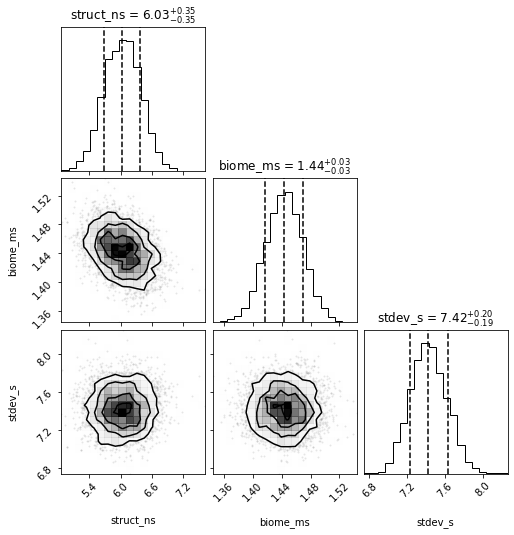

In [36]:
samples = np.array(list(zip(*[model_fits['124.1_thread_linear'].stan_variable(x) for x in linmod_vars])))
fig = corner(samples, labels=linmod_vars, quantiles=[0.16, 0.5, 0.84], show_titles=True)


The 95% credible interval of the model is plus-or-minus fourteen seconds, which strikes me as somewhat noisy. More importantly, though, check out the estimates for how long each seed takes to check. While structure seeds are handled in roughly six nanoseconds, biome seeds require almost *a millisecond and a half* to check. That's nearly six orders of magnitude slower! Anything we can do to minimize our time checking biomes should pay off in better runtimes.

This is one reason why AndyNovo put that biome cap in place, in fact. They observed that some structure seeds didn't seem to create any valid biome seed. One solution is to place a cap on the number of biome seeds you check, the rationale being that if you've checked sufficient numbers of them without finding a valid one, you can be pretty sure you'll never encounter one. There's enough data that you can see evidence for these dud structure seeds.

In [37]:
mask = table['category'].isin( ['124.1_linear_seedcount_opt','124.1_linear_seedcount_opttune',
                                 '124.1_linear_seedcount_optnon','124.1_thread_linear',
                                 '124.1_para_linear','124.1_para_blake3_64x'] )

fig = px.violin(table[mask], x='biomes', points='all', box=True, hover_data=['structs','times','biomes'], \
  orientation='h', violinmode='overlay', title='Biome checks for V1.2.4' )
fig.update_xaxes(title='number of biomes checked')
fig.update_yaxes(title=None)

At first blush there's gaps in the number of checked biomes, but unlike last time there's no "dead zone" where a range of biome checks will never show up. Instead, this looks more like a series of exponential distributions overlaid on each other, each starting at a 65,536 seed boundary. This is exactly the pattern you'd see if the odds of finding a seed drop below the odds of success if we'd given up and moved to another structure seed. The basic concept is sound.

But are the current caps optimal? Looking over the code, there's no justification for the numbers given. Let's fill that gap with [one of my favourite tools](https://did-dream-cheat.github.io/bayes_speedrun_cheating/methodology.html), Bayesian statistics.

While we're checking for a viable biome, we've got two hypotheses in mind: this structure seed will produce a viable biome, or it will not. As we're still checking biomes, by definition all our prior $x_\text{failure}$ checks have not led to a valid biome. The second hypothesis is easiest to express, since no matter how many biome seeds we check we're guaranteed to never find a valid biome. 

$$
p( \lnot \text{biome possible} | x_\text{failures} ) \propto 1 \cdot p( \lnot \text{biome possible} )
$$

Or, in English, the likelihood that a valid biome will never be found for a given structure seed, given $x_\text{failures}$ prior attempts to find a biome, is proportional to the odds of a structure seed never leading to a valid biome.

We can calculate the odds of this biome check succeeding, given the structure seed leads to a valid biome. Let's call that $p(\text{finding biome} | \text{biome possible})$. Since we've checked $x_\text{failures}$ seeds already, 

$$
p( x_\text{failures} | \text{biome_possible} ) = (1 - p(\text{finding biome} | \text{biome possible})^{x_\text{failures}}
$$

For the hypothesis that we'll find a valid biome, given $x_\text{failures}$, is proportional to the likelihood of $x_\text{failures}$ given this structure seed leads to a valid biome, multiplied by the odds of a structure seed leading to at least one valid biome. Or, in math,

$$
p( \text{biome possible} | x_\text{failures} ) \propto (1 - p(\text{finding biome} | \text{biome possible})^{x_\text{failures}} \cdot p( \text{biome possible} )
$$

The normalizing constant is the sum of these two hypotheses' likelihoods, since they're the only two possible. I never bothered to write it down because, [shock surprise](https://did-dream-cheat.github.io/bayes_speedrun_cheating/methodology.html#defining-cheating), I'm putting both hypotheses into a Bayes factor.

$$
BF = \frac{(1 - p(\text{finding biome} | \text{biome possible}))^{x_\text{failures}} \cdot p( \text{biome possible} )}{1 - p( \text{biome possible} )}
$$

When this value is greater than one, we place more credence on the current structure seed having a valid biome than it having no biome, and when it it less the opposite is true. Our behaviour hinges on this value: in the former case it makes sense to continue searching for a valid biome, while in the latter we're better off abandoning this structure seed. So we need to calculate when this value switches from greater than one to less than one. That happens when

$$
(1 - p(\text{finding biome} | \text{biome possible}))^{x_\text{failures}} \cdot p( \text{biome possible} ) < 1 - p( \text{biome possible} )
$$

From here, we just need to do some basic math to rearrange for the only unknown value, $x_\text{failures}$.

\begin{align}
(1 - p(\text{finding biome} | \text{biome possible}))^{x_\text{failures}}  &< \frac{1 - p( \text{biome possible} )}{p( \text{biome possible} )} \\
x_\text{failures} \log (1 - p(\text{finding biome} | \text{biome possible})) &< \log(1 - p( \text{biome possible} )) - \log({p( \text{biome possible} ))} \\
x_\text{failures} &> \frac{\log(1 - p( \text{biome possible} )) - \log({p( \text{biome possible} ))}}{\log (1 - p(\text{finding biome} | \text{biome possible}))}
\end{align}



Great! But there's a slight problem: I lied when I said we knew $p(\text{biome possible})$ and $p(\text{finding biome}|\text{biome possible})$. Those numbers are knowable, we'd just have to enumerate every possible structure seed to see if it produces a valid biome, but there's $2^{48}$ possible structure seeds. Worse, those numbers are specific to each FSG filter, so we'd have to repeat that census at least a half-dozen times. It would much more convenient if we could estimate those values, instead.

We can, and it involves your friend [and mine](https://did-dream-cheat.github.io/bayes_speedrun_cheating/methodology.html#conjugate-priors), conjugate priors. The basic idea is that we take a bunch of samples, then generate a posterior for our belief in the relevant parameters via conjugate priors. The sampling portion is already done for one of the four filters, thanks to all this benchmarking.

To estimate $p(\text{finding biome}|\text{biome possible})$, I'll invoke the [Gamma conjugate](https://en.wikipedia.org/wiki/Gamma_distribution#Conjugate_prior) to line up with the exponential distribution we observed in the charts. Since there's so much data the choice of prior doesn't matter much, so I'll stick with a Jeffrey's prior of $(\frac 1 2, 0)$.

In [38]:
mask = table['category'].isin( ['124.1_linear_seedcount_opt','124.1_linear_seedcount_opttune',
                                 '124.1_linear_seedcount_optnon','124.1_thread_linear'] )

finding_biome_alpha = sum(mask) + .5
finding_biome_beta = (((table[mask]['biomes'] - 1) % 65536) + 1).sum()

fig = px.line( x=np.linspace(1e-4,2e-4,1024), y=gamma(finding_biome_alpha, scale=1/finding_biome_beta).pdf( np.linspace(1e-4,2e-4,1024)) )
fig.update_xaxes(title='odds of finding a biome, given finding one is possible')
fig.update_yaxes(title='likelihood', showticklabels=False)

You can see our best guess for $p(\text{finding biome}|\text{biome possible})$ is about 174 in a million, but there's still a range of possible values it could be.

$p(\text{biome possible})$ will be described by the Beta conjugate instead, as there's only a fixed number of structure seeds to check. Again I'll start with a Jeffrey's prior, which for the Beta is $(\frac 1 2, \frac 1 2)$.

In [39]:
mask = table['category'].isin( ['124.1_linear_seedcount_opt','124.1_linear_seedcount_opttune',
                                 '124.1_linear_seedcount_optnon','124.1_thread_linear'] )

biome_possible_alpha = sum(mask) + .5
biome_possible_beta = np.sum((table[mask]['biomes'] - 1) // 65536) + .5

fig = px.line( x=np.linspace(0.9,1,1024), y=beta(biome_possible_alpha, biome_possible_beta).pdf( np.linspace(0.9,1,1024) ) )
fig.update_xaxes(title='odds of a valid biome')
fig.update_yaxes(title='likelihood', showticklabels=False)

Most structure seeds with this filter seem to have a valid biome, as our best guess for $p(\text{biome possible})$ is 93.6%. 

Combining those two distributions analytically via the above equation is very tricky, so I'll cheat and use numeric sampling instead. The result will be a "cloud" of biome cutoffs that cluster around our best guess for the optimal value.

In [40]:
n = 1024
finding_biome_samples = gamma(finding_biome_alpha, scale=1/finding_biome_beta).rvs( size=n )
biome_possible_samples = beta(biome_possible_alpha, biome_possible_beta).rvs( size=n )

biome_limit = [ceil( (mp.log1p( -bp ) - mp.log( bp ))/mp.log1p( -finding_biome_samples[i] ) ) for i,bp in enumerate(biome_possible_samples) ]

fig = px.violin( x=biome_limit, points='all', box=True, orientation='h', violinmode='overlay', title='Ideal Reset Point for Filter 1 (Village-only)' )
fig.update_xaxes(title='reset point')
fig.update_yaxes(title=None)


For the Village seed filter of version 1.2.4, the optimal biome cutoff is around 15,475, but there's a range of plausible alternatives. Narrowing things down further means throwing more data at the math.

We've also got three more filters to optimize. You know what that means.

In [41]:
!wget -O biomes.124.1.tsv "https://docs.google.com/spreadsheets/d/17jwthnDLdXd0fcvI6vpqYqEQdBGyH96TdJxPYADAfXw/export?format=tsv"

--2021-05-15 15:37:02--  https://docs.google.com/spreadsheets/d/17jwthnDLdXd0fcvI6vpqYqEQdBGyH96TdJxPYADAfXw/export?format=tsv
Resolving docs.google.com (docs.google.com)... 108.177.12.138, 108.177.12.139, 108.177.12.100, ...
Connecting to docs.google.com (docs.google.com)|108.177.12.138|:443... connected.
HTTP request sent, awaiting response... 307 Temporary Redirect
Location: https://doc-0k-bs-sheets.googleusercontent.com/export/l5l039s6ni5uumqbsj9o11lmdc/1bkruhmecu8pua9fl2pemr50jc/1621093020000/102479941717694276056/*/17jwthnDLdXd0fcvI6vpqYqEQdBGyH96TdJxPYADAfXw?format=tsv [following]
--2021-05-15 15:37:03--  https://doc-0k-bs-sheets.googleusercontent.com/export/l5l039s6ni5uumqbsj9o11lmdc/1bkruhmecu8pua9fl2pemr50jc/1621093020000/102479941717694276056/*/17jwthnDLdXd0fcvI6vpqYqEQdBGyH96TdJxPYADAfXw?format=tsv
Resolving doc-0k-bs-sheets.googleusercontent.com (doc-0k-bs-sheets.googleusercontent.com)... 108.177.12.132, 2607:f8b0:400c:c08::84
Connecting to doc-0k-bs-sheets.googleuserconte

In [42]:
filters  = list()
times    = list()
times_r  = list()
checks   = list()
biomes   = list()
failures = dict()

with open('biomes.124.1.tsv', 'rt') as f:
    for line in f:
        results = five_var.match(line)
        if results:
            filters.append( results.group(1) )
            times.append( float(results.group(2)) )
            checks.append( int(results.group(3)) )
            biomes.append( int(results.group(4)) )
            times_r.append( float(results.group(5)) )
            continue

filter_set   = set(filters)
filter_table = pd.DataFrame( {'filters':filters, 'times':times, 'checks':checks, 'biomes':biomes, 'times_r':times_r} )
filter_table['structs'] = filter_table['checks'] - filter_table['biomes']

len(filter_table)

10115

That translates into roughly 2,500 datapoints per filter. Note that we're not using the prior information we had for the Village-only filter; this is a sanity check to see how much the estimated cut-off can change. 

Time to convert all that data into hyperparameters. I'll also add the odds of finding a structure seed with a valid biome.

In [43]:
filter_conjpriors = {x:([.5]*6) for x in filter_set}   
  # finding_biome_alpha/beta, biome_possible_alpha/beta, finding_struct_alpha/beta

for filter in filter_set:
  mask = filter_table['filters'] == filter

  filter_conjpriors[filter][0] += sum(mask) + .5
  filter_conjpriors[filter][1] += (((filter_table[mask]['biomes'] - 1) % 65536) + 1).sum()

  filter_conjpriors[filter][2] += sum(mask) + .5
  filter_conjpriors[filter][3] += np.sum((filter_table[mask]['biomes'] - 1) // 65536) + .5

  filter_conjpriors[filter][4] += sum(mask) + .5
  filter_conjpriors[filter][5] += filter_table[mask]['structs'].sum()


We might as well handle the newcomer first: how common are valid structure seeds for each type of filter? 

In [44]:
print( f"{'':8s}\tp( structure seed | structure seed possible )" )
print( f"{'variant':8s}\t{'mean':8s}\tstd.dev" )

for filter in sorted(filter_set):
  print( f"{filter:8s}\t{filter_conjpriors[filter][4]/filter_conjpriors[filter][5]:.2e}" + \
        f"\t{np.sqrt(filter_conjpriors[filter][4])/filter_conjpriors[filter][5]:.2e}" )

        	p( structure seed | structure seed possible )
variant 	mean    	std.dev
0       	6.20e-05	1.23e-06
1       	1.43e-09	2.84e-11
2       	8.25e-10	1.64e-11
3       	6.91e-07	1.37e-08


I tried to put this in a chart, but the best guesses for each filter covered too much range. We go from a guess of 62 valid structure seeds per million tested for filter 0 (RSG Overworld) to 0.83 per billion for filter 2 (Shipwreck-only).

Let's get back to the question at hand. Where is our credence in $p(\text{finding biome}|\text{biome possible})$ concentrated, for each filter?

In [45]:
biome_finding_est = [ [], [], [] ]
for filter in filter_set:
  x = np.exp(np.linspace(np.log(3e-5),np.log(5e-3),1024))
  biome_finding_est[0].extend( x )
  biome_finding_est[1].extend( gamma(filter_conjpriors[filter][0], scale=1/filter_conjpriors[filter][1]).pdf(x) )
  biome_finding_est[2].extend( [filter] * n )

fig = px.line( x=biome_finding_est[0], y=biome_finding_est[1], color=biome_finding_est[2], log_x=True )
fig.update_xaxes(title='odds of finding a biome, given finding one is possible')
fig.update_yaxes(title='likelihood', showticklabels=False)

The range isn't as extreme as before, so I can just barely fit it all on a graph. The rate of finding a valid biome seed, given a structure seed that has one, happens to coincide with the numeric order of filters. To give some sense of scale, the lowest rate implies there's a mere three valid biome seeds per structure seed for that filter, while the highest implies there's about 164.

In [46]:
biome_finding_est = [ [], [], [] ]
for filter in filter_set:
  x = np.linspace(0.5,1,1024)
  biome_finding_est[0].extend( x )
  biome_finding_est[1].extend( beta(filter_conjpriors[filter][2], filter_conjpriors[filter][3]).pdf(x) )
  biome_finding_est[2].extend( [filter] * n )

fig = px.line( x=biome_finding_est[0], y=biome_finding_est[1], color=biome_finding_est[2] )
fig.update_xaxes(title='odds of a valid biome')
fig.update_yaxes(title='likelihood', showticklabels=False)

The details for $p(\text{biome possible})$ are different, but the big picture is roughly the same. Only a bit more than half the structure seeds for filters 2 and 3 (Jungle-only) have a valid biome, while the majority of both filter 0 and 1 (Village-only) structure seeds have at least one.

In [47]:
biome_estimates = [ [], [] ]

for filter in filter_set:
  finding_biome_samples = gamma(filter_conjpriors[filter][0], scale=1/filter_conjpriors[filter][1]).rvs( size=n )
  biome_possible_samples = beta(filter_conjpriors[filter][2], filter_conjpriors[filter][3]).rvs( size=n )

  biome_estimates[0].extend( [filter] * n )
  biome_estimates[1].extend( \
    [ceil( (mp.log1p( -bp ) - mp.log( bp ))/mp.log1p( -finding_biome_samples[i] ) ) for i,bp in enumerate(biome_possible_samples) ] )

fig = px.violin( y=biome_estimates[0], x=biome_estimates[1], points='all', color=biome_estimates[0], box=True, \
      orientation='h', violinmode='overlay', title='Ideal Reset Point for Four Filters of v1.2.4' )
fig.update_xaxes(title='reset point')
fig.update_yaxes(title=None)

The details lead to some subtle differences in the optimal threshold. Since valid biome seeds are rare with filter 1, yet most structure seeds have a biome, the threshold before giving up is quite high. The other filters favour smaller cutoffs, since they either have plenty of structure seeds with biomes and biomes per structure seed, or few biomes per seed but few valid structure seeds.

You can see the result we calculated for filter 1 much earlier is in the ballpark of this one, though a bit on the high end. That bodes well for the other estimates.

In [48]:
summary_dict = {'variant':[], 'median':[], 'mean':[], 'std.dev':[], 'count':[], 'measure':[]}
for alg in ['124.1_nom','124.1_linear_seedcount','124.1_linear_seedcount_optnon',
          '124.1_effrng_seedcount_opt','124.1_para_blake3_64x_biomes','124.1_para_linear_biomes',
          '124.1_para_blake3_64x','124.1_para_linear']:

  mask = (table['category'] == alg)
  temp = table[mask]['times_r'].agg( ['count','median','mean','std'] )
  if temp['count'] == 0:
    temp = table[mask]['times'].agg( ['count','median','mean','std'] )
    summary_dict['measure'].append( 'user-space seconds' )
  else:
    summary_dict['measure'].append( 'real seconds' )

  summary_dict['variant'].append( alg )
  summary_dict['median'].append( temp['median'] )
  summary_dict['mean'].append( temp['mean'] )
  summary_dict['std.dev'].append( temp['std'] )
  summary_dict['count'].append( temp['count'] )

print( f"{'':32s}\tEXECUTION TIME" )
print( f"{'variant':32s}\tmedian\tmean\tstd.dev\tcount\tmeasure" )

for idx,row in pd.DataFrame(summary_dict).sort_values( by='mean', ascending=False ).iterrows():
  print( f"{row['variant']:32s}\t{row['median']:.2f}\t{row['mean']:.2f}\t{row['std.dev']:.2f}\t{int(row['count'])}\t{row['measure']}" )

                                	EXECUTION TIME
variant                         	median	mean	std.dev	count	measure
124.1_nom                       	68.83	132.54	171.19	576	user-space seconds
124.1_effrng_seedcount_opt      	25.96	36.25	34.56	583	user-space seconds
124.1_linear_seedcount          	21.00	31.04	31.33	673	user-space seconds
124.1_linear_seedcount_optnon   	9.91	18.15	25.78	767	real seconds
124.1_para_blake3_64x_biomes    	6.21	7.53	5.69	2105	real seconds
124.1_para_blake3_64x           	6.00	7.35	5.50	2104	real seconds
124.1_para_linear               	4.24	5.24	4.27	2101	real seconds
124.1_para_linear_biomes        	4.24	5.15	3.80	2100	real seconds


Unfortunately, this optimization is pretty lackluster. In the case of BLAKE3, in fact, intelligent biome thresholds actually lead to a *slowdown*. My best guess is that this is due to the search strategy used: BLAKE3 picks a random biome seed to examine, so there's no guarantee it won't pick the same one twice. This means it tests fewer biome seeds than the raw number suggests, therefore the effective cutoff is lower than the one we impose. That's not what we want, since bailing out on biomes early means we're checking another billion structure seeds for filter 1 on average. 

As the numbers for linear search suggest above, checking too many biome seeds doesn't cause much of a time penalty; remember that both `para_linear` and `para_blake3_64x` test all possible biome seeds for each structure seed, so imposing a cap of one quarter that amount only leads to a 2% speed-up in the linear case. Those numbers are specific to filter 1, though, and greater speed-ups may be possible for filters with lower filter caps.

Filter 1 in particular happens to have a very large cutoff value, so there's a reasonable chance of repeats. If [this math](https://math.stackexchange.com/a/1988197) is correct, the expected number of repeats we get when checking 15,475 biome seeds is

In [49]:
15475 + 65536*(-1 + mp.exp( mp.log1p( -1/65536 )*15475 ) )

mpf('1691.2571536194591')

so the effective number of biomes checked is actually

In [50]:
65536*(1 - mp.exp( mp.log1p( -1/65536 )*15475 ) )

mpf('13783.742846380541')

We can use this math to calculate the adjusted biome goal for the BLAKE3 variant.

In [51]:
print( f"{'filter':8s}\tgoal\tadjusted goal" )

for filter in sorted(filter_set):
  fb_mean = filter_conjpriors[filter][0]/filter_conjpriors[filter][1]
  bp_mean = filter_conjpriors[filter][2]/(filter_conjpriors[filter][2]+filter_conjpriors[filter][3])

  target = ceil( (mp.log1p( -bp_mean ) - mp.log( bp_mean ))/mp.log1p( -fb_mean ) )
  left = target
  right = 32768

  while (right - left) > 1:
    middle = (left + right) >> 1

    val = 65536*(1 - mp.exp( mp.log1p( -1/65536 )*middle ) )
    if val > target:
      right = middle
    else:
      left = middle

  left_v = (65536*(1 - mp.exp( mp.log1p( -1/65536 )*left ) ))
  right_v = (65536*(1 - mp.exp( mp.log1p( -1/65536 )*right ) ))

  if np.abs(left_v-target) < np.abs(right_v-target):
    adj = left
  else:
    adj = right
  print( f"{filter:8s}\t{target}\t{right}" )

filter  	goal	adjusted goal
0       	1265	1278
1       	14895	16898
2       	2735	2794
3       	5434	5673


Those numbers come from the second dataset, though. We have better data for filter 1.

In [52]:
target = 15475
left = target
right = 32768

while (right - left) > 1:
  middle = (left + right) >> 1

  val = 65536*(1 - mp.exp( mp.log1p( -1/65536 )*middle ) )
  if val > target:
    right = middle
  else:
    left = middle

left_v = (65536*(1 - mp.exp( mp.log1p( -1/65536 )*left ) ))
right_v = (65536*(1 - mp.exp( mp.log1p( -1/65536 )*right ) ))

if np.abs(left_v-target) < np.abs(right_v-target):
  adj = left
else:
  adj = right
print( f"{'1':8s}\t{target}\t{right}" )

1       	15475	17653


Let's add these newer targets to the BLAKE3 variant. I'll also experiment a bit with the linear search variant, by using the less accurate and lower biome cutoff given by the second dataset to see how badly performance is impacted.

In [53]:
summary_dict = {'variant':[], 'median':[], 'mean':[], 'std.dev':[], 'count':[], 'measure':[]}
for alg in ['124.1_nom','124.1_linear_seedcount','124.1_linear_seedcount_optnon',
          '124.1_effrng_seedcount_opt','124.1_para_blake3_64x_biomes_adj','124.1_para_linear_biomes_mean',
          '124.1_para_blake3_64x','124.1_para_linear']:

  mask = (table['category'] == alg)
  temp = table[mask]['times_r'].agg( ['count','median','mean','std'] )
  if temp['count'] == 0:
    temp = table[mask]['times'].agg( ['count','median','mean','std'] )
    summary_dict['measure'].append( 'user-space seconds' )
  else:
    summary_dict['measure'].append( 'real seconds' )

  summary_dict['variant'].append( alg )
  summary_dict['median'].append( temp['median'] )
  summary_dict['mean'].append( temp['mean'] )
  summary_dict['std.dev'].append( temp['std'] )
  summary_dict['count'].append( temp['count'] )

print( f"{'':32s}\tEXECUTION TIME" )
print( f"{'variant':32s}\tmedian\tmean\tstd.dev\tcount\tmeasure" )

for idx,row in pd.DataFrame(summary_dict).sort_values( by='mean', ascending=False ).iterrows():
  print( f"{row['variant']:32s}\t{row['median']:.2f}\t{row['mean']:.2f}\t{row['std.dev']:.2f}\t{int(row['count'])}\t{row['measure']}" )

                                	EXECUTION TIME
variant                         	median	mean	std.dev	count	measure
124.1_nom                       	68.83	132.54	171.19	576	user-space seconds
124.1_effrng_seedcount_opt      	25.96	36.25	34.56	583	user-space seconds
124.1_linear_seedcount          	21.00	31.04	31.33	673	user-space seconds
124.1_linear_seedcount_optnon   	9.91	18.15	25.78	767	real seconds
124.1_para_blake3_64x           	6.00	7.35	5.50	2104	real seconds
124.1_para_blake3_64x_biomes_adj	6.03	7.12	4.99	808	real seconds
124.1_para_linear               	4.24	5.24	4.27	2101	real seconds
124.1_para_linear_biomes_mean   	4.03	5.11	3.80	808	real seconds


The revised biome cutoff did help the BLAKE3 variant. The linear variant wasn't impacted by the less accurate estimate, either. That is quite handy, as it suggests the second dataset is sufficiently large to provide reasonable estimates for all the filters. 

## Other Changes

As mentioned above, almost all these changes break the original FSG token. I took advantage of that to give it a minor redesign. The new format is as follows:

> [VERSION][FILTER]-[nonce]-[SEED]-[checks]-[biomes]-[TIMESTAMP]

Where "version" is the version of the program used to generate the seed, "filter" is the chosen filter type, "nonce" a 8 byte value drawn from a cryptographically-secure random number source, "seed" the eventual seed generated by the code, "checks" is the total number of structure and biome seeds tested, "biomes" the number of biome seeds tested, and finally "timestamp" is the number of microseconds since January 1st, 1970. All values are encoded in hexadecimal, and capitalization dictates whether or not the alphabetical portions of hex numbers are capitalized. The only numbers that are zero-padded are the version, filter, nonce, and seed values. Every other field is variable length.

The time measure was increased in resolution, as the old code's measure of the number of seconds since January 1st, 1970 could easily fit in four bytes but was presented as an eight-byte hex number. The BLAKE3 variant also uses this value in the HMAC key, so increasing the resolution was preferred to truncating the number of bytes used. This also makes it much tougher to recreate a pre-calculated token by starting the code at a specific time. Few computers cannot calculate the time since January 1st, 1970 with nanosecond precision, but Linux computers can manage it with sub-microsecond precision.

The old code hashed the source code and used that to help seed Salsa20. That was removed for the new code, as it offered no additional security beyond a simple version number check. If you want to add the hash back in, the BLAKE3 variant has some room in the key of the hash function to accomodate it. For the linear variant, your best bet is to XOR the hash tag with the nonce (though this makes it trivial to recover the hash tag).

The old code had two different versioning systems, whereas the new standardizes that to one single-byte field. The time it took to generate the token was removed, as that number can fluctuate based on a number of factors that runners cannot control (such as the speed of the VMs used by repl.it) or should be irrelevant (invalidating a token because someone's computer is too slow or fast).

There have also been a few quality-of-life tweaks added to the seed-finding code.

```
$ ./seed.124.1_para_linear_biomes --help
FSG Seed Filter v255

 USAGE: ./seed.124.1_para_linear_biomes [--help] [--verbose] [--threads THREADS] [--filter FILTER]
          [--check SEED]

 --help:    Print this message.
 --verbose: Print out additional information while running.
 --threads: Set the number of threads to use. Defaults to 0, or use all
             available.
 --check:   Print the weights each interior filter applies to SEED, a
             Minecraft seed.
 --filter:  Use the given filter when evaluating seeds. Choices are:
               0: RSG overworld
               1: Village Only
               2: Shipwreck Only
               3: Jungle Only

 Each long option has a short version consisting of their first letter.
   For instance, "-v" is identical to "--verbose".

$ ./seed.124.1_para_blake3_64x_biomes_adj 
FSG v255 Village Only, 4 threads
STATUS: 474554241 structs, 2175 biomes, 148.8M checks/s                                 
Seed: -1549023490846560735
Filtered 564079088 seeds did 2671 biome checks
Verification Token:
FF01-397ae3980e7fb81a-EA80C357975AEE21-13829f3-a6f-5C23CFC3DED29
Time to complete in nanoseconds: 3848010022
```

The `STATUS` line updates once per second with the latest statistics.

## Future Work

As extensive as the above is, there is still room for improvement. My invokation of sixty-four blocks for BLAKE3 was arbitrary, and could be further tuned. 

The biome cutoffs are only calculated for one version of the FSG seed generator, so there's more work to be done estimating their ideal cutoffs. This requires:

1. Use the linear search variant.
2. Modify all values of `biome_cutoff[]` to be 65536.
3. Run the code, but force the code to use only a single thread.

There's [a Python script](https://github.com/hjhornbeck/fsg_token_speedup/blob/main/src/estimate_cutoff.py) to help iteratively calculate biome cutoffs. 